# Importing Necessary Libraries

In [ ]:
# Core
import os
import numpy as np
import matplotlib.pyplot as plt

# TensorFlow Datasets (ONLY for loading)
import tensorflow_datasets as tfds

# PyTorch (for later compatibility)
import torch
from torch.utils.data import Dataset
from torchvision import transforms

# Reproducibility
import random
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Loading Dataset

In [ ]:
# Load Oxford Flowers-102
dataset, dataset_info = tfds.load(
    "oxford_flowers102",
    with_info=True,
    as_supervised=True
)

# Data Exploration

In [ ]:
dataset_info

tfds.core.DatasetInfo(
    name='oxford_flowers102',
    full_name='oxford_flowers102/2.1.1',
    description="""
    The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly
    occurring in the United Kingdom. Each class consists of between 40 and 258
    images. The images have large scale, pose and light variations. In addition,
    there are categories that have large variations within the category and several
    very similar categories.
    
    The dataset is divided into a training set, a validation set and a test set. The
    training set and validation set each consist of 10 images per class (totalling
    1020 images each). The test set consists of the remaining 6149 images (minimum
    20 per class).
    
    Note: The dataset by default comes with a test size larger than the train size.
    For more info see this
    [issue](https://github.com/tensorflow/datasets/issues/3022).
    """,
    homepage='https://www.robots.ox.ac.uk/~vgg/data/flowers/102

In [ ]:
dataset.keys()

dict_keys(['train', 'test', 'validation'])

# Dataset Wrapper
Define a PyTorch Dataset class for image-label mapping.

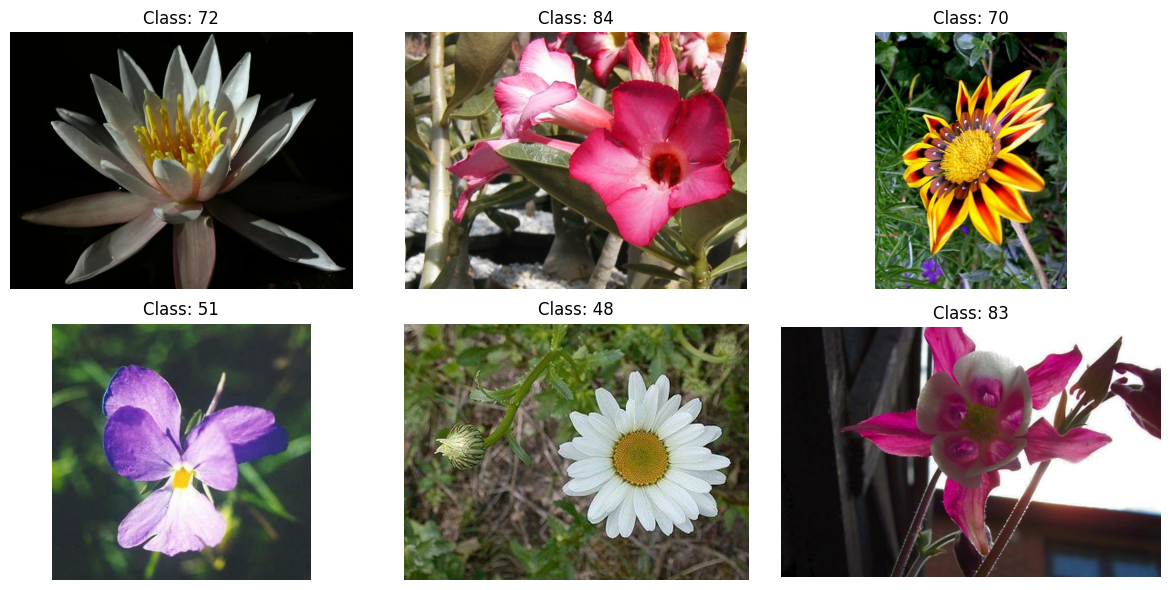

In [ ]:
def show_samples(ds, num=6):
    plt.figure(figsize=(12, 6))
    for i, (img, label) in enumerate(ds.take(num)):
        plt.subplot(2, 3, i + 1)
        plt.imshow(img.numpy())
        plt.title(f"Class: {label.numpy()}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_samples(dataset["train"])

In [ ]:
shapes = []
for img, _ in dataset["train"].take(100):
    shapes.append(img.shape)

set(shapes)

{TensorShape([500, 500, 3]),
 TensorShape([500, 505, 3]),
 TensorShape([500, 516, 3]),
 TensorShape([500, 530, 3]),
 TensorShape([500, 531, 3]),
 TensorShape([500, 539, 3]),
 TensorShape([500, 542, 3]),
 TensorShape([500, 546, 3]),
 TensorShape([500, 550, 3]),
 TensorShape([500, 551, 3]),
 TensorShape([500, 553, 3]),
 TensorShape([500, 581, 3]),
 TensorShape([500, 624, 3]),
 TensorShape([500, 625, 3]),
 TensorShape([500, 626, 3]),
 TensorShape([500, 637, 3]),
 TensorShape([500, 649, 3]),
 TensorShape([500, 657, 3]),
 TensorShape([500, 664, 3]),
 TensorShape([500, 666, 3]),
 TensorShape([500, 667, 3]),
 TensorShape([500, 668, 3]),
 TensorShape([500, 672, 3]),
 TensorShape([500, 673, 3]),
 TensorShape([500, 681, 3]),
 TensorShape([500, 700, 3]),
 TensorShape([500, 709, 3]),
 TensorShape([500, 718, 3]),
 TensorShape([500, 723, 3]),
 TensorShape([500, 740, 3]),
 TensorShape([500, 750, 3]),
 TensorShape([500, 752, 3]),
 TensorShape([500, 761, 3]),
 TensorShape([500, 762, 3]),
 TensorShape([

# Pre-Processing

In [ ]:
IMAGE_SIZE = 224

train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

eval_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [ ]:
class Flowers102Dataset(Dataset):
    def __init__(self, tf_dataset, transform=None):
        self.data = list(tf_dataset)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img, label = self.data[idx]
        img = img.numpy()
        label = int(label.numpy())

        if self.transform:
            img = self.transform(img)

        return img, label

In [ ]:
train_ds = Flowers102Dataset(dataset["train"], transform=train_transform)
val_ds   = Flowers102Dataset(dataset["validation"], transform=eval_transform)
test_ds  = Flowers102Dataset(dataset["test"], transform=eval_transform)

print(len(train_ds), len(val_ds), len(test_ds))

1020 1020 6149


# Level- 1 Baseline Model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import models
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


# DataLoader Initialization
Create batch iterators for the training, validation, and test datasets using multi-process loading.

In [ ]:
BATCH_SIZE = 32

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

#Model Architecture and Layer Freezing
Load a pre-trained ResNet-50, modify the output head for 102 classes, and selectively unfreeze the final residual block for fine-tuning.

In [ ]:
NUM_CLASSES = 102

model = models.resnet50(pretrained=True)

# Replace classifier
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)

# Freeze everything
for param in model.parameters():
    param.requires_grad = False

# Unfreeze last residual block
for param in model.layer4.parameters():
    param.requires_grad = True

# FC is already trainable after replacement

# Move model to device (CRITICAL)
model = model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-4
)

#Training Loop Definition
Define the core training function to perform a single forward and backward pass across the training dataset while tracking loss and accuracy.

In [ ]:
def train_one_epoch(model, loader):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return running_loss / len(loader), correct / total

In [ ]:
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return correct / total

#Training Execution
Run the training and validation loops across multiple epochs while tracking and logging accuracy metrics.

In [ ]:
EPOCHS = 7

train_accs, val_accs = [], []

for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader)
    val_acc = evaluate(model, val_loader)

    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch [{epoch+1}/{EPOCHS}] | "
          f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

Epoch [1/7] | Train Acc: 0.1853 | Val Acc: 0.4637
Epoch [2/7] | Train Acc: 0.7618 | Val Acc: 0.6588
Epoch [3/7] | Train Acc: 0.9314 | Val Acc: 0.7735
Epoch [4/7] | Train Acc: 0.9686 | Val Acc: 0.8608
Epoch [5/7] | Train Acc: 0.9922 | Val Acc: 0.8873
Epoch [6/7] | Train Acc: 1.0000 | Val Acc: 0.9000
Epoch [7/7] | Train Acc: 1.0000 | Val Acc: 0.9098


In [ ]:
next(model.parameters()).device

device(type='cpu')

#Test Accuracy

In [ ]:
test_acc = evaluate(model, test_loader)
print("Test Accuracy:", test_acc)

Test Accuracy: 0.8853472109286062


#Random Inference Visualization
Perform single-image inference on a random sample from the test dataset and visualize the results.

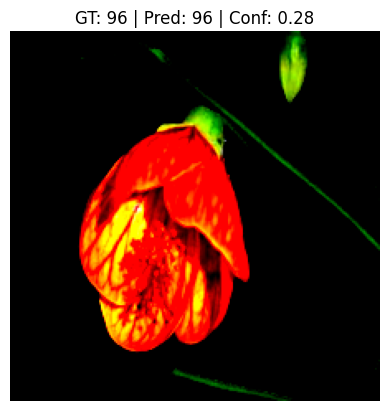

In [ ]:
import random

model.eval()
idx = random.randint(0, len(test_ds) - 1)

img, label = test_ds[idx]
input_img = img.unsqueeze(0).to(device)

with torch.no_grad():
    output = model(input_img)
    prob = torch.softmax(output, dim=1)
    pred = torch.argmax(prob, dim=1).item()

plt.imshow(img.permute(1,2,0).cpu())
plt.title(f"GT: {label} | Pred: {pred} | Conf: {prob[0][pred]:.2f}")
plt.axis("off")
plt.show()

#Model Export and Persistence
Mount Google Drive and save the trained model weights to a specified directory for permanent storage.

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

MODEL_PATH = "/content/drive/MyDrive/flowers_resnet50_level_new.pth"
torch.save(model.state_dict(), MODEL_PATH)

print("Model saved to:", MODEL_PATH)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved to: /content/drive/MyDrive/flowers_resnet50_level_new.pth
